C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\1546348620.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Profit'] = data['Profit'].ewm(alpha=alpha).mean()
C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\1546348620.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sales'] = data['Sales'].ewm(alpha=alpha).mean()


Training Data (After Exponential Smoothing)
   Row ID        Order ID Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2014-11-08  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156 2014-11-08  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688 2014-06-12   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966 2014-10-11  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966 2014-10-11  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

          Category  Sub-Category  \
0        Furniture

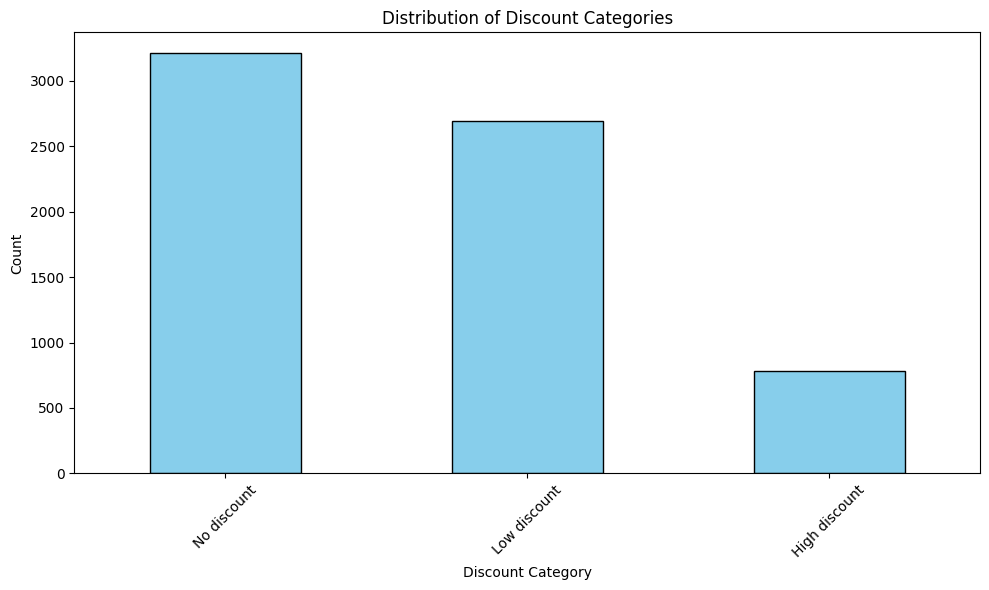

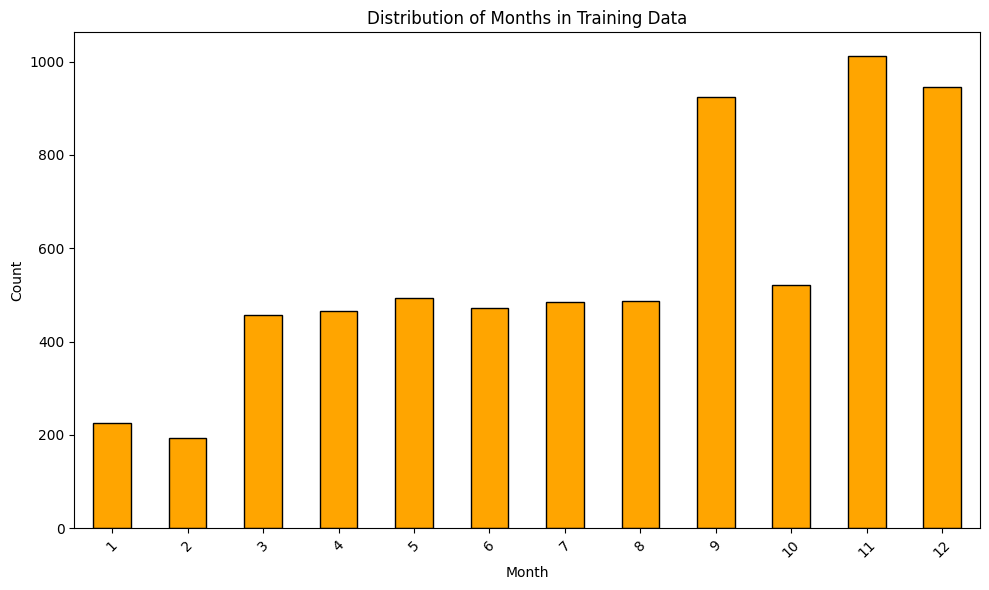

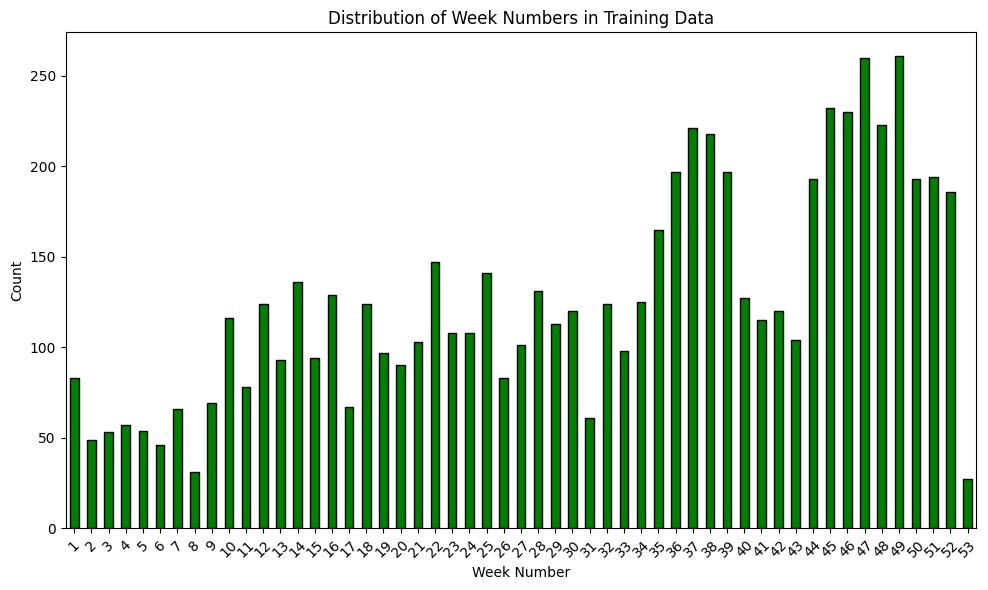

Training Data (After Exponential Smoothing)
(6682, 24)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Path to the CSV file
file_path = r"C:\Users\Beheerder\Documents\DSAI master\Q5 Courses\Research Topics in Data mining\Sample - Superstore.csv"

# Load the CSV file into a pandas DataFrame with specified encoding
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Categorize 'Discount' values into "No discount", "Low discount", and "High discount"
def categorize_discount(discount):
    if discount == 0:
        return "No discount"
    elif 0 < discount <= 0.3:  
        return "Low discount"
    else:
        return "High discount"

# Apply the categorization function to the 'Discount' column
df['Discount Category'] = df['Discount'].apply(categorize_discount)

# Extract Month and Week Number from 'Order Date'
df['Month'] = df['Order Date'].dt.month  # Extract month as an integer (1 for January, 12 for December)
df['Week Number'] = df['Order Date'].dt.isocalendar().week  # Extract ISO week number

# Adjust the 'Order Date' for all dates before 31 December 2016 to make them all in the year 2014
cutoff_date = pd.Timestamp('2016-12-31')

def adjust_to_2014(date):
    # Handle leap year dates like Feb 29 by checking if the adjusted year supports that day
    try:
        if date <= cutoff_date:
            return date.replace(year=2014)
        else:
            return date
    except ValueError:
        # If there is an invalid date, default to February 28
        return datetime(2014, 2, 28)

df['Order Date'] = df['Order Date'].apply(adjust_to_2014)

# Now you can use 'Order Date Adjusted' for both the training and test datasets

# Training dataset: all data with an adjusted order date before or on 31 December 2016
train_data = df[df['Order Date'] <= cutoff_date]

# Test dataset: all data with the order date after 31 December 2016
test_data = df[df['Order Date'] > cutoff_date]

# Apply medium exponential smoothing to reduce the impact of outliers (on 'Profit' and 'Sales' columns)
def apply_exponential_smoothing(data, alpha=0.15):
    # Apply exponential smoothing to 'Profit' and 'Sales'
    data['Profit'] = data['Profit'].ewm(alpha=alpha).mean()
    data['Sales'] = data['Sales'].ewm(alpha=alpha).mean()
    return data

# Apply smoothing to both train and test datasets
train_data = apply_exponential_smoothing(train_data)
test_data = apply_exponential_smoothing(test_data)

# Display the first few rows of the training dataset and the discount categories
print("Training Data (After Exponential Smoothing)")
print(train_data.head())

# Plot the distribution of discount categories in the training data
def plot_discount_category_distribution(df):
    value_counts = df['Discount Category'].value_counts()
    
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Discount Categories')
    plt.xlabel('Discount Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot the distribution of discount categories in the training data
plot_discount_category_distribution(train_data)

# Plot the distribution of months in the training data
def plot_month_distribution(df):
    value_counts = df['Month'].value_counts().sort_index()  # Sort by month index
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Distribution of Months in Training Data')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the distribution of week numbers in the training data
def plot_week_distribution(df):
    value_counts = df['Week Number'].value_counts().sort_index()  # Sort by week number
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='green', edgecolor='black')
    plt.title('Distribution of Week Numbers in Training Data')
    plt.xlabel('Week Number')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the functions to plot the distribution of months and week numbers in the training data
plot_month_distribution(train_data)
plot_week_distribution(train_data)

print("Training Data (After Exponential Smoothing)")
print(train_data.shape)


C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\2567847625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Year-Week'] = train_data['Order Date'].dt.to_period('M')
C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\2567847625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Year-Week'] = test_data['Order Date'].dt.to_period('M')


(6682, 25)


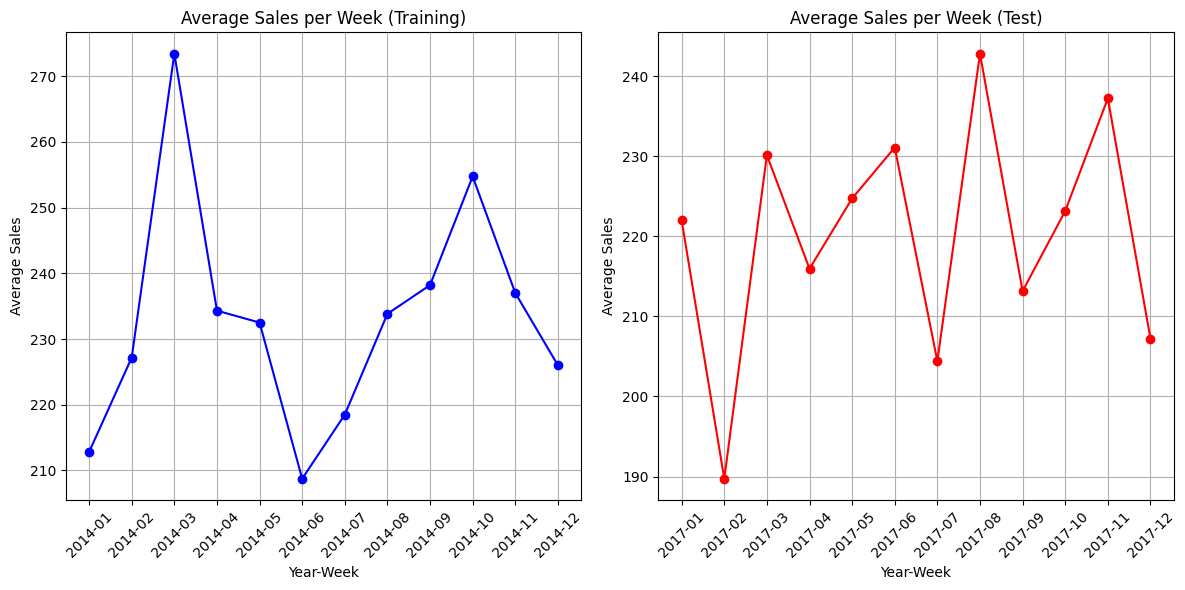

In [3]:
# Extract the year-week format from 'Order Date' to group by week
train_data['Year-Week'] = train_data['Order Date'].dt.to_period('M')
test_data['Year-Week'] = test_data['Order Date'].dt.to_period('M')
print(train_data.shape)
# Group by 'Year-Week' and calculate the average sales per week for both datasets
avg_sales_per_week_train = train_data.groupby('Year-Week')['Sales'].mean()
avg_sales_per_week_test = test_data.groupby('Year-Week')['Sales'].mean()

# Plot the average sales per week for the training dataset
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(avg_sales_per_week_train.index.astype(str), avg_sales_per_week_train.values, marker='o', linestyle='-', color='b')
plt.title('Average Sales per Week (Training)')
plt.xlabel('Year-Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(True)

# Plot the average sales per week for the test dataset
plt.subplot(1, 2, 2)
plt.plot(avg_sales_per_week_test.index.astype(str), avg_sales_per_week_test.values, marker='o', linestyle='-', color='r')
plt.title('Average Sales per Week (Test)')
plt.xlabel('Year-Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [63]:
import numpy as np
from itertools import product, combinations

# Define your quality measure functions
def entropy_quality(subgroup_size, total_size, rest_size):
    if subgroup_size == 0 or rest_size == 0:
        return 0  # Avoid NaN
    # Calculate entropy based on the formula given
    p_s = subgroup_size / total_size
    p_r = rest_size / total_size
    return -p_s * np.log(p_s) - p_r * np.log(p_r)

def distribution_difference(subgroup_data, rest_data, total_size):
    if rest_data == 0:
        return 0  # Avoid NaN
    # Use the third formula from your definition
    return (1 / total_size) * np.sum(np.abs((subgroup_data - rest_data) / rest_data))

def quality_measure(subgroup, df):
    # Total data size (unique people in the entire dataset)
    total_size = df['Customer ID'].nunique()
    
    # Subgroup size (unique people in the subgroup)
    subgroup_size = subgroup['Customer ID'].nunique()
    
    # Rest of the data size
    rest_size = total_size - subgroup_size
    
    # Use regular sales data for both subgroup and rest of the data
    sales_subgroup = subgroup['Sales'].mean()
    sales_rest = df.loc[~df.index.isin(subgroup.index), 'Sales'].mean()
    
    # Calculate entropy quality
    entropy = entropy_quality(subgroup_size, total_size, rest_size)
    
    # Calculate distribution difference in sales (without smoothing)
    distribution_diff = distribution_difference(sales_subgroup, sales_rest, total_size)
    
    # Total quality measure
    return entropy * distribution_diff

# Subgroup discovery based on combinations of attribute values
def discover_subgroups(df, attributes, k=5):
    best_subgroups = []
    
    # Iterate over all possible subsets of attributes (including empty subset)
    for subset_length in range(1, len(attributes) + 1):
        for subset in combinations(attributes, subset_length):
            # Generate all possible combinations of attribute values for this subset of attributes
            attribute_values = [df[attribute].unique() for attribute in subset]
            all_combinations = list(product(*attribute_values))
            
            # Iterate over all combinations of attribute values
            for combination in all_combinations:
                # Create a boolean mask to filter the dataframe for this subgroup
                mask = np.ones(len(df), dtype=bool)
                subgroup_description = {}
                
                for i, attribute in enumerate(subset):
                    mask = mask & (df[attribute] == combination[i])
                    subgroup_description[attribute] = combination[i]
                
                # Define the subgroup using the mask
                subgroup = df[mask]
                
                # Only consider subgroups with at least one unique customer
                if subgroup['Customer ID'].nunique() > 0:
                    # Calculate the quality measure for the subgroup
                    quality = quality_measure(subgroup, df)
                    
                    # Append the subgroup with its attributes, quality, and unique size (based on Customer ID)
                    best_subgroups.append({
                        "Attributes": subgroup_description,  # Combination of attribute values
                        "Quality": quality,
                        "Group Size (Unique Customers)": subgroup['Customer ID'].nunique()
                    })
    
    # Sort the subgroups by quality in descending order and return the top k
    best_subgroups = sorted(best_subgroups, key=lambda x: x['Quality'], reverse=True)[:k]
    
    return best_subgroups

# Example: Subgroup discovery based on 'Sub-Category', 'Segment', 'Region', and 'Ship Mode'
attributes = ['Sub-Category', 'Segment', 'Region', 'Ship Mode']  # Variables for subgroup discovery
best_subgroups_train = discover_subgroups(train_data, attributes, k=250)

# Convert the list of dictionaries (best_subgroups) into a DataFrame for better visualization
subgroup_details_df_train = pd.DataFrame(best_subgroups_train)

# Display the entire DataFrame (all rows)
pd.set_option('display.max_rows', None)

# Output the DataFrame
subgroup_details_df_train


,Attributes,Quality,Group Size (Unique Customers)
0,{'Sub-Category': 'Machines'},0.000397,74
1,"{'Sub-Category': 'Machines', 'Ship Mode': 'Sta...",0.000308,46
2,{'Sub-Category': 'Tables'},0.000292,179
3,{'Sub-Category': 'Copiers'},0.000274,42
4,"{'Sub-Category': 'Copiers', 'Ship Mode': 'Stan...",0.000248,23
5,"{'Sub-Category': 'Machines', 'Segment': 'Consu...",0.000229,43
6,"{'Sub-Category': 'Tables', 'Ship Mode': 'Stand...",0.000213,125
7,"{'Sub-Category': 'Machines', 'Region': 'South'}",0.000205,12
8,"{'Sub-Category': 'Copiers', 'Region': 'Central'}",0.000194,13
9,"{'Sub-Category': 'Machines', 'Region': 'East'}",0.000192,28


In [64]:
import pandas as pd
import numpy as np

# Define the indicator function
def indicator_function(A_S, A_ref, Y_S, Y_ref, theta):
    # If any of the values are NaN, return NaN
    if pd.isna(Y_S) or pd.isna(Y_ref):
        return np.nan
    
    if A_S != A_ref and (Y_S - Y_ref) > theta:
        return 1
    elif A_S != A_ref and (Y_S - Y_ref) < -theta:
        return -1
    else:
        return 0

# Detect Turning Points based on indicator values, skip NaN in turning points detection
# Detect Turning Points based on indicator values, skip NaN in turning points detection
def detect_turning_points(indicator_series, n_min=2):
    turning_points = []
    current_value = None
    run_length = 0
    
    for t in range(len(indicator_series)):
        # Skip NaN values when detecting turning points
        if pd.isna(indicator_series[t]):
            continue  # Ignore NaN values for turning points
        
        if current_value is None:  # Initialization for the first non-NaN value
            current_value = indicator_series[t]
            run_length = 1
            continue

        if indicator_series[t] == current_value:
            run_length += 1
        else:
            # Check if the run length is valid (n_min)
            if run_length >= n_min:
                # Only append the turning point if the strategy (current_value) has changed
                if not turning_points or turning_points[-1][1] != current_value:
                    turning_points.append((t - run_length, current_value))
            current_value = indicator_series[t]
            run_length = 1

    # Handle the last segment if it meets the conditions
    if run_length >= n_min:
        # Ensure the last turning point isn't the same as the current one
        if not turning_points or turning_points[-1][1] != current_value:
            turning_points.append((len(indicator_series) - run_length, current_value))

    return turning_points


# Apply the indicator function to each subgroup and detect turning points
def analyze_subgroups_with_indicator(subgroups, df, controllable_attributes, target_attribute, time_unit='W', percentage=5, n_min=2):
    updated_subgroups = []
    
    # Ensure "Order Date" is in datetime format
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    
    # Create a new time period column based on months ('M') or weeks ('W')
    df['Time Period'] = df['Order Date'].dt.to_period(time_unit)  # 'M' for months, 'W' for weeks
    
    # DEBUG: Print unique time periods to confirm it's by months
    print(f"Unique time periods (should be months): {df['Time Period'].unique()}")

    # Define the complete time index for months
    complete_time_index = pd.period_range(start=df['Time Period'].min(), end=df['Time Period'].max(), freq=time_unit)

    for subgroup in subgroups:
        # Extract the subgroup data based on attributes (constant controllable value for the whole subgroup)
        mask = np.ones(len(df), dtype=bool)
        for attr, value in subgroup['Attributes'].items():
            mask = mask & (df[attr] == value)
        subgroup_data = df[mask]

        # Fix `A_S_t` as the discount category of this subgroup
        A_S_t = subgroup_data[controllable_attributes].unique()[0]
        
        # Initialize the indicator values list
        indicator_values = []
        
        # Create the actual "subgroup" (matching controlled value) and "reference group" (excluding controlled value)
        subgroup_controlled = subgroup_data[subgroup_data[controllable_attributes] == A_S_t]
        reference_data = subgroup_data[subgroup_data[controllable_attributes] != A_S_t]
        
        if subgroup_controlled.empty or reference_data.empty:
            print("Skipping empty subgroup or reference group")
            continue

        A_ref_t = reference_data[controllable_attributes].mode()[0]  # Reference controllable attribute using mode for categorical data
        Y_ref_t = reference_data.groupby('Time Period')[target_attribute].mean()  # Group by time period and take mean of target attribute
        theta = percentage / 100 * Y_ref_t.mean()  # Calculate the threshold as a percentage of Y_ref mean
        
        # Group the subgroup data by time period (month/week) and calculate the mean for numeric columns
        subgroup_period = subgroup_controlled.groupby('Time Period').agg({target_attribute: 'mean'})  # Mean for numeric

        # Reindex to ensure we have consistent time periods
        subgroup_period = subgroup_period.reindex(complete_time_index, fill_value=np.nan)
        Y_ref_t = Y_ref_t.reindex(complete_time_index, fill_value=np.nan)

        for month, row in subgroup_period.iterrows():
            Y_S_t = row[target_attribute]  # Target variable value for the subgroup at the current time period
            
            # Use mean of reference group for comparison
            Y_ref_monthly = Y_ref_t.loc[month] if pd.notna(Y_ref_t.loc[month]) else np.nan  # Return NaN if the reference value is missing

            indicator_value = indicator_function(A_S_t, A_ref_t, Y_S_t, Y_ref_monthly, theta)
            
            # Add indicator value (NaNs are allowed here)
            indicator_values.append(indicator_value)
        
        # Detect turning points based on the indicator values (ignoring NaNs in detection)
        turning_points = detect_turning_points(indicator_values, n_min=n_min)
        
        # Ensure there is a non-NaN turning point at t = 0
        if pd.isna(indicator_values[0]):
            # Find the first non-NaN value and treat it as the new starting point
            for idx, val in enumerate(indicator_values):
                if not pd.isna(val):
                    turning_points.insert(0, (idx, val))
                    break
        else:
            # Add turning point at t = 0 if it's valid (not NaN)
            turning_points.insert(0, (0, indicator_values[0]))  
        
        # Exclude turning point at t = 0 from the quality count
        quality = len([tp for tp in turning_points if tp[0] != 0])
        
        # Update the subgroup with the detected turning points and add the discount category
        updated_subgroups.append({
            "Attributes": subgroup['Attributes'],
            "Quality": quality,  # Exclude t = 0 turning points from the quality measure
            "Group Size (Unique Customers)": subgroup['Group Size (Unique Customers)'],
            "Turning Points": turning_points,  # Add the detected turning points (including t = 0)
            "Indicator Values": indicator_values,  # Add the calculated indicator values
            "Discount Category": A_S_t  # Add the fixed discount category for this subgroup
        })
    
    return updated_subgroups

# Example subgroups (replace 'best_subgroups_train' with actual subgroup data)
subgroups = best_subgroups_train

# Analyze the subgroups and find turning points (with consistent time periods for months)
controllable_attributes = 'Discount Category'  # Using 'Discount Category' as the controllable attribute
target_attribute = 'Profit'  # The target variable for the analysis
time_unit = 'M'  # 'M' for months, 'W' for weeks
percentage = 5  # Percentage difference threshold for turning point detection
n_min = 2  # Minimum number of consecutive indicator values to confirm a turning point

# Analyze the subgroups and detect turning points (on a monthly or weekly basis)
updated_subgroups = analyze_subgroups_with_indicator(subgroups, train_data, controllable_attributes, target_attribute, time_unit, percentage, n_min)

# Convert the updated subgroups into a DataFrame for better visualization
subgroup_details_df = pd.DataFrame(updated_subgroups)

# Sort the resulting dataframe by the "Quality" column in descending order
subgroup_details_df_sorted = subgroup_details_df.sort_values(by="Quality", ascending=False)

# Display the sorted DataFrame
pd.set_option('display.max_rows', None)

# Print the entire DataFrame with turning points
subgroup_details_df_sorted


C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\1151873167.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order Date'] = pd.to_datetime(df['Order Date'])
C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\1151873167.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time Period'] = df['Order Date'].dt.to_period(time_unit)  # 'M' for months, 'W' for weeks


Unique time periods (should be months): <PeriodArray>
['2014-11', '2014-06', '2014-10', '2014-12', '2014-05', '2014-08', '2014-09',
 '2014-01', '2014-07', '2014-03', '2014-04', '2014-02']
Length: 12, dtype: period[M]
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group
Skipping empty subgroup or reference group


,Attributes,Quality,Group Size (Unique Customers),Turning Points,Indicator Values,Discount Category
178,"{'Sub-Category': 'Binders', 'Segment': 'Corpor...",4,41,"[(2, -1), (3, -1), (6, 1), (9, -1)]","[nan, nan, -1, -1, nan, 1, 1, nan, -1, nan, -1...",High discount
203,"{'Sub-Category': 'Phones', 'Segment': 'Consume...",4,41,"[(2, 1), (2, 1), (4, -1), (8, 1)]","[nan, nan, 1, 1, -1, -1, 1, nan, 1, nan, 1, 1]",No discount
218,"{'Sub-Category': 'Paper', 'Segment': 'Consumer...",4,92,"[(0, -1), (1, 1), (4, -1), (6, 1), (8, -1)]","[-1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1]",No discount
12,"{'Sub-Category': 'Tables', 'Region': 'West'}",4,72,"[(2, -1), (4, -1), (6, 1), (10, -1)]","[nan, nan, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1]",Low discount
215,"{'Segment': 'Home Office', 'Region': 'West', '...",4,87,"[(0, 0), (1, 1), (5, -1), (8, 1), (10, -1)]","[0, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1]",No discount
56,"{'Sub-Category': 'Fasteners', 'Segment': 'Cons...",4,72,"[(2, -1), (3, -1), (6, 1), (8, -1)]","[nan, nan, -1, -1, -1, nan, 1, 1, -1, -1, 1, -1]",Low discount
23,"{'Sub-Category': 'Tables', 'Segment': 'Corpora...",4,48,"[(2, 1), (4, 1), (7, -1), (9, 1)]","[nan, nan, 1, nan, nan, 1, 1, -1, -1, 1, 1, 1]",No discount
180,{'Sub-Category': 'Supplies'},4,112,"[(2, 1), (2, 1), (7, -1), (9, 1)]","[nan, nan, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1]",No discount
202,"{'Sub-Category': 'Supplies', 'Region': 'West',...",3,28,"[(6, 1), (8, -1), (10, 1)]","[nan, nan, nan, nan, nan, nan, 1, -1, nan, -1,...",No discount
108,"{'Sub-Category': 'Furnishings', 'Segment': 'Co...",3,74,"[(0, 1), (3, -1), (5, 1), (8, -1)]","[1, nan, -1, nan, -1, 1, 1, -1, -1, nan, -1, -1]",Low discount


Code below makes sure you get filtered subgroups with quality higher than 1, and no rows where at least 3 NaN values are present in the list are discarded


In [65]:

# Filter the dataframe where Quality is at least 1 and at most 3 NaN values in Indicator Values
filtered_subgroups = subgroup_details_df_sorted[
    (subgroup_details_df_sorted['Quality'] >= 1) &
    (subgroup_details_df_sorted['Indicator Values'].apply(lambda x: np.isnan(x).sum() <= 0))
]

# Count the number of rows that meet the conditions
num_filtered_rows = filtered_subgroups.shape[0]

# Display the filtered DataFrame and the number of rows
print(f"Number of rows after filtering: {num_filtered_rows}")
filtered_subgroups


Number of rows after filtering: 34


,Attributes,Quality,Group Size (Unique Customers),Turning Points,Indicator Values,Discount Category
218,"{'Sub-Category': 'Paper', 'Segment': 'Consumer...",4,92,"[(0, -1), (1, 1), (4, -1), (6, 1), (8, -1)]","[-1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1]",No discount
215,"{'Segment': 'Home Office', 'Region': 'West', '...",4,87,"[(0, 0), (1, 1), (5, -1), (8, 1), (10, -1)]","[0, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1]",No discount
61,{'Sub-Category': 'Labels'},3,202,"[(0, 1), (3, -1), (5, 1), (9, -1)]","[1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1]",No discount
65,"{'Sub-Category': 'Paper', 'Region': 'West'}",3,221,"[(0, -1), (1, 1), (8, -1), (10, 1)]","[-1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1]",No discount
38,"{'Sub-Category': 'Phones', 'Segment': 'Consumer'}",3,200,"[(0, 0), (1, -1), (3, 1), (5, -1)]","[0, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1]",Low discount
76,"{'Sub-Category': 'Paper', 'Region': 'West', 'S...",3,140,"[(0, -1), (1, 1), (5, -1), (10, 1)]","[-1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1]",No discount
147,"{'Sub-Category': 'Binders', 'Ship Mode': 'Stan...",3,393,"[(0, -1), (5, 1), (8, -1), (10, 1)]","[-1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1]",Low discount
128,"{'Segment': 'Corporate', 'Region': 'Central', ...",2,110,"[(0, 1), (0, 1), (3, -1), (5, 1)]","[1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1]",No discount
149,{'Sub-Category': 'Envelopes'},2,156,"[(0, -1), (0, -1), (2, 1), (6, -1)]","[-1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1]",Low discount
135,{'Sub-Category': 'Binders'},2,543,"[(0, -1), (0, -1), (2, 1), (8, -1)]","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 0]",Low discount


Plot turning points on plot of the respective training data:

C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\3353055161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Order Date'] = pd.to_datetime(train_data['Order Date'])
C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\3353055161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Time Period'] = train_data['Order Date'].dt.to_period(time_unit)  # 'M' for months, 'W' for weeks


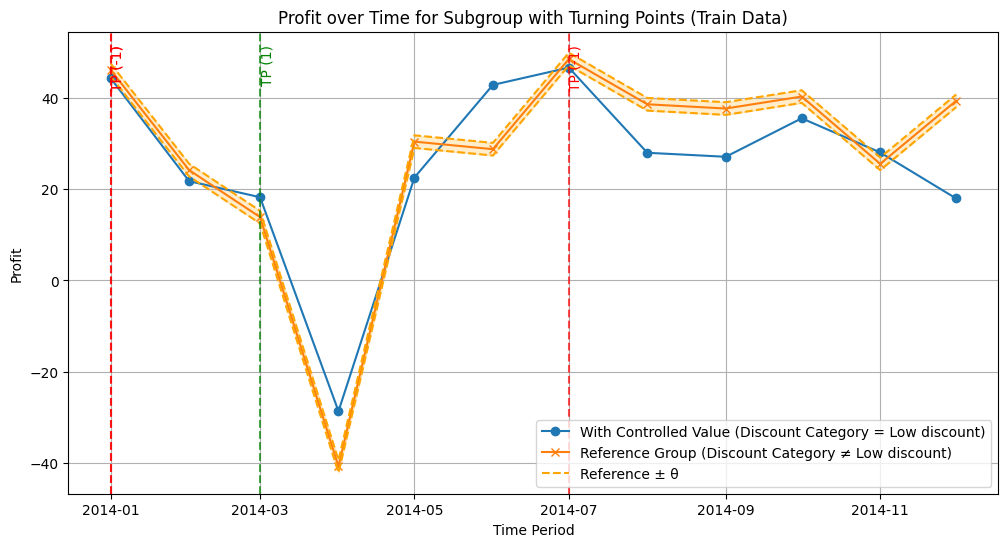

C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\3353055161.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Order Date'] = pd.to_datetime(test_data['Order Date'])
C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\3353055161.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Time Period'] = test_data['Order Date'].dt.to_period('M')  # 'M' for months


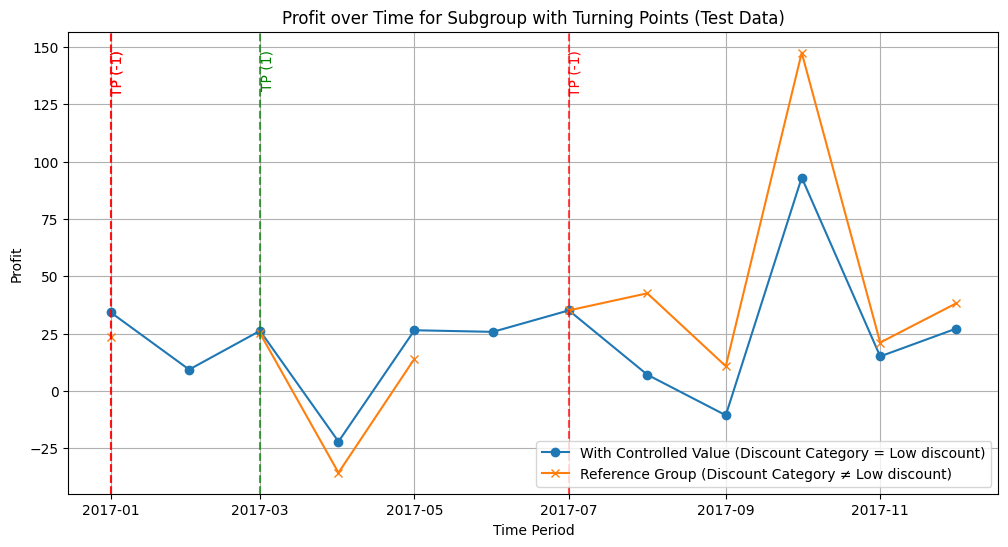

In [66]:
# Ensure 'Order Date' is in datetime format and create 'Time Period' column for the train dataset
train_data['Order Date'] = pd.to_datetime(train_data['Order Date'])
train_data['Time Period'] = train_data['Order Date'].dt.to_period(time_unit)  # 'M' for months, 'W' for weeks

# Define the complete time index for consistent time periods in the train dataset
complete_time_index_train = pd.period_range(start=train_data['Time Period'].min(), end=train_data['Time Period'].max(), freq=time_unit)

# Extract the desired subgroup from the sorted DataFrame
first_row = filtered_subgroups.iloc[8]  # Adjust the index as needed
attributes = first_row['Attributes']
A_S_t = first_row['Discount Category']  # The controlled variable value
controllable_attributes = 'Discount Category'  # The controllable attribute
target_attribute = 'Profit'  # The target variable for analysis
percentage = 5  # The percentage used in the theta calculation

# Create mask matching all subgroup attributes (including controllable attribute) for train data
mask = np.ones(len(train_data), dtype=bool)
for attr, value in attributes.items():
    mask &= (train_data[attr] == value)
data_with_controlled_value_train = train_data[mask]

# Reference data: data matching subgroup attributes except controllable attribute, and controllable attribute not equal to A_S_t in train data
mask_reference = np.ones(len(train_data), dtype=bool)
for attr, value in attributes.items():
    if attr != controllable_attributes:
        mask_reference &= (train_data[attr] == value)
data_without_controlled_value_train = train_data[mask_reference & (train_data[controllable_attributes] != A_S_t)]

# Group the data by 'Time Period' and calculate the mean of the target attribute for train data
grouped_with_train = data_with_controlled_value_train.groupby('Time Period')[target_attribute].mean().reindex(complete_time_index_train, fill_value=np.nan)
grouped_without_train = data_without_controlled_value_train.groupby('Time Period')[target_attribute].mean().reindex(complete_time_index_train, fill_value=np.nan)

# Calculate theta (θ) as a percentage of the overall mean of the reference group for train data
theta_train = percentage / 100 * grouped_without_train.mean()  # Scalar value

# Calculate the upper and lower thresholds for train data
upper_threshold_train = grouped_without_train + theta_train
lower_threshold_train = grouped_without_train - theta_train

# Extract the indicator values and turning points from the same sorted DataFrame
indicator_values = first_row['Indicator Values']
turning_points = first_row['Turning Points']

# Create a DataFrame for indicator values for the train data
indicator_df_train = pd.DataFrame({
    'Time Period': complete_time_index_train,
    'Indicator Value': indicator_values
})
indicator_df_train.set_index('Time Period', inplace=True)

# Plot for the train dataset
plt.figure(figsize=(12, 6))
plt.plot(grouped_with_train.index.to_timestamp(), grouped_with_train.values, marker='o', label=f"With Controlled Value ({controllable_attributes} = {A_S_t})")
plt.plot(grouped_without_train.index.to_timestamp(), grouped_without_train.values, marker='x', label=f"Reference Group ({controllable_attributes} ≠ {A_S_t})")

# Plot the θ thresholds around the reference plotline for train data
plt.plot(upper_threshold_train.index.to_timestamp(), upper_threshold_train.values, linestyle='--', color='orange', label=f'Reference ± θ')
plt.plot(lower_threshold_train.index.to_timestamp(), lower_threshold_train.values, linestyle='--', color='orange')

# Fill the area between the thresholds for visualization for train data
plt.fill_between(upper_threshold_train.index.to_timestamp(), lower_threshold_train.values, upper_threshold_train.values, color='orange', alpha=0.2)

# Plot vertical lines at the turning point periods (train data)
for tp in turning_points:
    index, value = tp  # index in indicator_values
    time_period = complete_time_index_train[index].to_timestamp()
    # Choose color based on the turning point value
    if value == 1:
        color = 'green'  # Positive turning point
    elif value == -1:
        color = 'red'    # Negative turning point
    else:
        color = 'grey'   # Neutral
    plt.axvline(x=time_period, color=color, linestyle='--', alpha=0.7)
    # Optionally, annotate the turning point
    plt.text(time_period, plt.ylim()[1]*0.95, f'TP ({value})', rotation=90, verticalalignment='top', color=color)

plt.xlabel('Time Period')
plt.ylabel(target_attribute)
plt.title('Profit over Time for Subgroup with Turning Points (Train Data)')
plt.legend()
plt.grid(True)
plt.show()

# NOW PLOT THE TEST DATA WITH THE SAME TURNING POINTS

# Ensure 'Order Date' is in datetime format and create 'Time Period' column for the test dataset
test_data['Order Date'] = pd.to_datetime(test_data['Order Date'])
test_data['Time Period'] = test_data['Order Date'].dt.to_period('M')  # 'M' for months

# Define the complete time index for consistent time periods in the test dataset
complete_time_index_test = pd.period_range(start=test_data['Time Period'].min(), end=test_data['Time Period'].max(), freq='M')

# Create mask matching all subgroup attributes (including controllable attribute) for test data
mask = np.ones(len(test_data), dtype=bool)
for attr, value in attributes.items():
    mask &= (test_data[attr] == value)
data_with_controlled_value_test = test_data[mask]

# Reference data: data matching subgroup attributes except controllable attribute, and controllable attribute not equal to A_S_t in test data
mask_reference = np.ones(len(test_data), dtype=bool)
for attr, value in attributes.items():
    if attr != controllable_attributes:
        mask_reference &= (test_data[attr] == value)
data_without_controlled_value_test = test_data[mask_reference & (test_data[controllable_attributes] != A_S_t)]

# Group the data by 'Time Period' and calculate the mean of the target attribute for test data
grouped_with_test = data_with_controlled_value_test.groupby('Time Period')[target_attribute].mean().reindex(complete_time_index_test, fill_value=np.nan)
grouped_without_test = data_without_controlled_value_test.groupby('Time Period')[target_attribute].mean().reindex(complete_time_index_test, fill_value=np.nan)

# Plot for the test dataset (with only the turning points from train dataset)
plt.figure(figsize=(12, 6))
plt.plot(grouped_with_test.index.to_timestamp(), grouped_with_test.values, marker='o', label=f"With Controlled Value ({controllable_attributes} = {A_S_t})")
plt.plot(grouped_without_test.index.to_timestamp(), grouped_without_test.values, marker='x', label=f"Reference Group ({controllable_attributes} ≠ {A_S_t})")

# Plot vertical lines at the turning point periods (test data)
for tp in turning_points:
    index, value = tp  # index in indicator_values
    time_period = complete_time_index_test[index].to_timestamp()
    # Choose color based on the turning point value
    if value == 1:
        color = 'green'  # Positive turning point
    elif value == -1:
        color = 'red'    # Negative turning point
    else:
        color = 'grey'   # Neutral
    plt.axvline(x=time_period, color=color, linestyle='--', alpha=0.7)
    # Optionally, annotate the turning point
    plt.text(time_period, plt.ylim()[1]*0.95, f'TP ({value})', rotation=90, verticalalignment='top', color=color)

plt.xlabel('Time Period')
plt.ylabel(target_attribute)
plt.title('Profit over Time for Subgroup with Turning Points (Test Data)')
plt.legend()
plt.grid(True)
plt.show()



Test Data


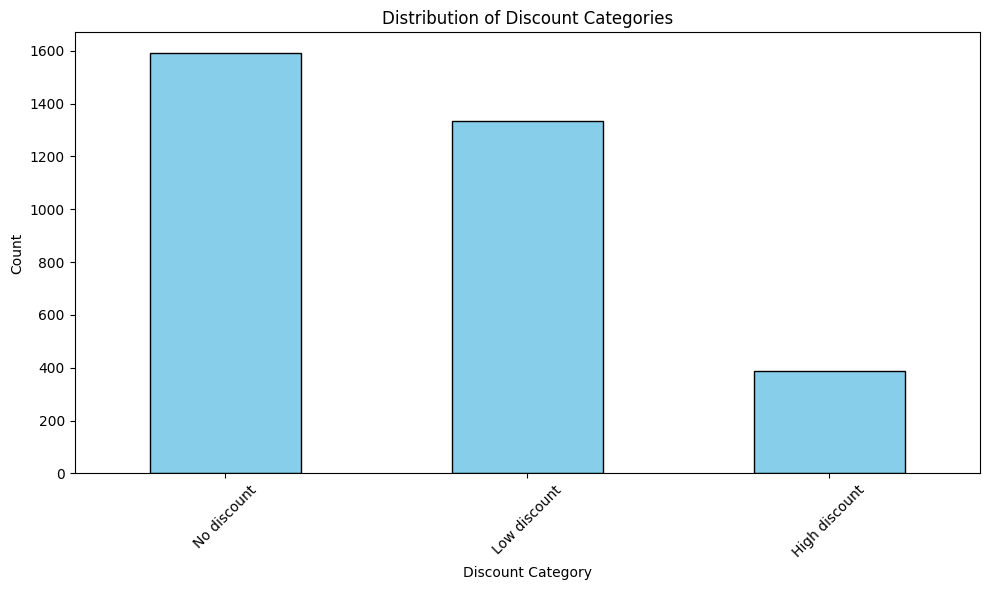

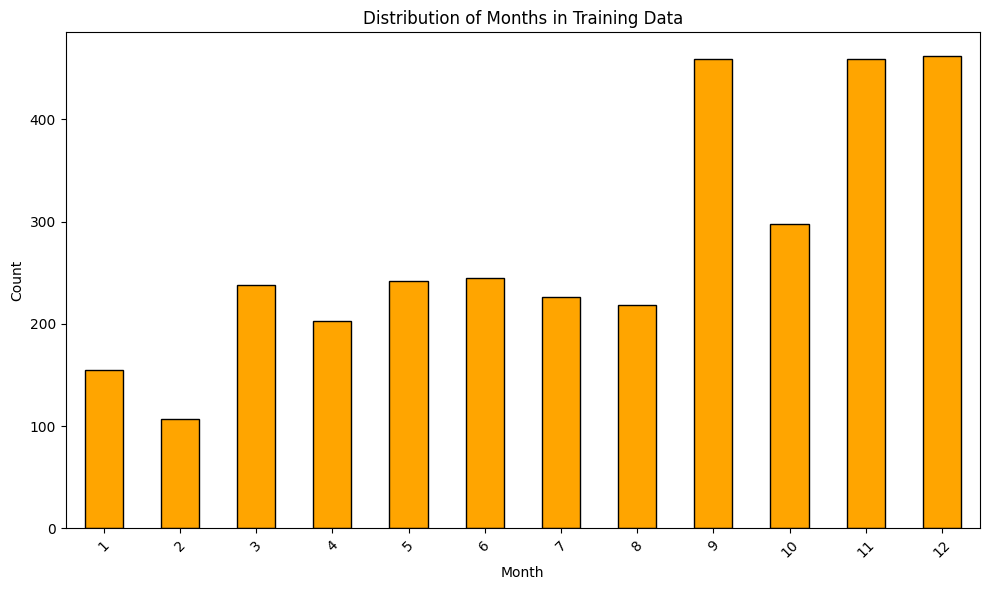

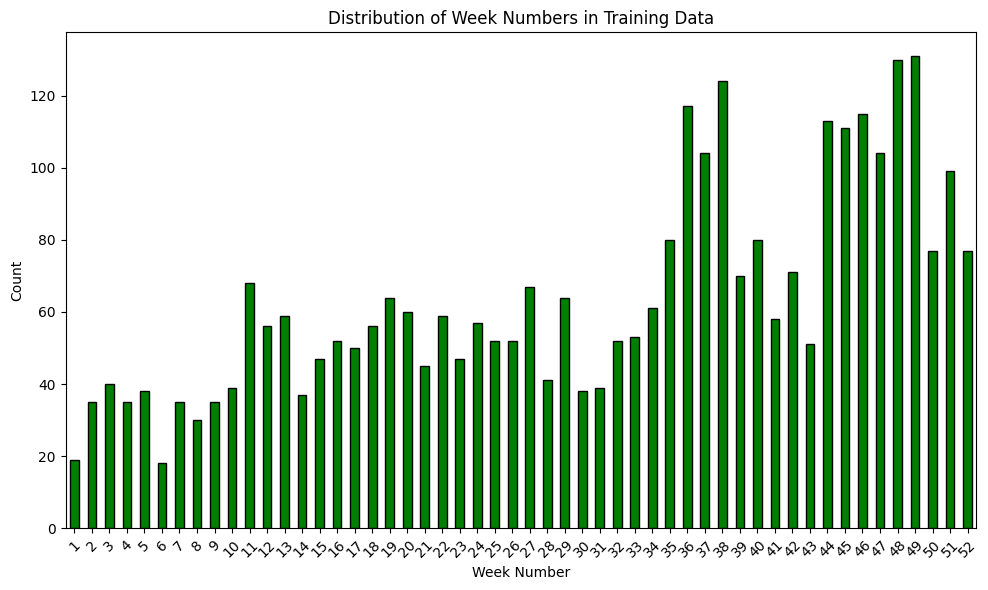

In [11]:
# Plot the distribution of discount categories in the test data
print("\nTest Data")

# Plot the distribution of discount categories in the test data
plot_discount_category_distribution(test_data)

# Plot the distribution of months in the test data
plot_month_distribution(test_data)

# Plot the distribution of week numbers in the test data
plot_week_distribution(test_data)


Make plot for turning points of train data (but then on unseen data):

Calculate mean and stdev whe using reular temporal EMM (take conrollable action that is maximizing)

In [61]:
import pandas as pd

def compare_and_maximize(subgroups, df, controllable_attribute, target_attribute):
    """
    For each subgroup, this function compares the average of the non-reference group (subgroup)
    with the reference group. It adds the higher average to a total and calculates the overall 
    mean, variance, and standard deviation across all subgroups.

    Parameters:
    - subgroups: DataFrame of subgroups to compare (filtered_subgroups).
    - df: The complete dataset (DataFrame).
    - controllable_attribute: The controllable attribute to compare (e.g., 'Discount Category').
    - target_attribute: The target variable being analyzed (e.g., 'Profit').

    Returns:
    - A tuple containing the overall mean, variance, and standard deviation of the maximum values
      from all subgroup comparisons.
    """
    max_values = []  # Store the maximum values for each subgroup

    # Loop through each subgroup and perform comparison
    for _, subgroup in subgroups.iterrows():
        attributes = subgroup['Attributes']
        A_S_t = subgroup['Discount Category']  # The controlled variable value

        # Create mask matching all subgroup attributes (including controllable attribute)
        mask = np.ones(len(df), dtype=bool)
        for attr, value in attributes.items():
            mask &= (df[attr] == value)
        data_with_controlled_value = df[mask]

        # Reference data: data matching subgroup attributes except controllable attribute, 
        # and controllable attribute not equal to A_S_t
        mask_reference = np.ones(len(df), dtype=bool)
        for attr, value in attributes.items():
            if attr != controllable_attribute:
                mask_reference &= (df[attr] == value)
        data_without_controlled_value = df[mask_reference & (df[controllable_attribute] != A_S_t)]

        # Group the data by 'Time Period' and calculate the mean of the target attribute
        grouped_with = data_with_controlled_value.groupby('Time Period')[target_attribute].mean()
        grouped_without = data_without_controlled_value.groupby('Time Period')[target_attribute].mean()

        # Calculate the means of the subgroup (non-reference group) and reference group
        subgroup_mean = grouped_with.mean()
        reference_mean = grouped_without.mean()

        # DEBUG: Print each subgroup comparison for verification
        print(f"Subgroup: {attributes}, Subgroup Mean: {subgroup_mean}, Reference Mean: {reference_mean}")

        # Add the maximum of the two means to the list of maximum values
        if not np.isnan(subgroup_mean) and not np.isnan(reference_mean):
            max_values.append(max(subgroup_mean, reference_mean))

    # Calculate the overall mean, variance, and standard deviation of the maximum values
    if len(max_values) > 0:
        overall_mean = np.mean(max_values)
        overall_variance = np.var(max_values, ddof=1)  # Sample variance (ddof=1)
        overall_std_dev = np.std(max_values, ddof=1)   # Sample standard deviation (ddof=1)
    else:
        overall_mean = np.nan
        overall_variance = np.nan
        overall_std_dev = np.nan

    return overall_mean, overall_variance, overall_std_dev

# Example usage:
# Assuming 'filtered_subgroups' is a DataFrame representing subgroups, and 'df' is the test dataset
overall_mean, overall_variance, overall_std_dev = compare_and_maximize(
    filtered_subgroups, 
    test_data, 
    controllable_attribute='Discount Category', 
    target_attribute='Profit'
)

print(f"Overall Mean of Maximum Values: {overall_mean}")
print(f"Overall Variance of Maximum Values: {overall_variance}")
print(f"Overall Standard Deviation of Maximum Values: {overall_std_dev}")


Subgroup: {'Sub-Category': 'Art', 'Ship Mode': 'First Class'}, Subgroup Mean: 22.860995150094507, Reference Mean: 26.68081918574946
Subgroup: {'Sub-Category': 'Art', 'Ship Mode': 'Second Class'}, Subgroup Mean: 13.507231044801886, Reference Mean: 13.301467371709716
Subgroup: {'Sub-Category': 'Paper', 'Segment': 'Consumer', 'Ship Mode': 'First Class'}, Subgroup Mean: 32.67040101500361, Reference Mean: 35.62554436147339
Subgroup: {'Sub-Category': 'Binders', 'Ship Mode': 'Second Class'}, Subgroup Mean: 56.01830728688217, Reference Mean: 52.22595790857051
Subgroup: {'Sub-Category': 'Appliances', 'Segment': 'Corporate', 'Ship Mode': 'Standard Class'}, Subgroup Mean: 27.454836001639773, Reference Mean: 5.362902335862152
Subgroup: {'Segment': 'Home Office', 'Region': 'West', 'Ship Mode': 'Standard Class'}, Subgroup Mean: 22.89400765284658, Reference Mean: 7.914427818114597
Subgroup: {'Sub-Category': 'Paper', 'Segment': 'Consumer', 'Region': 'East'}, Subgroup Mean: 39.65561078571728, Reference

Clculate mean and stdev for THEMM on unseen data

In [62]:
def calculate_maximizing_strategy(subgroup_data, reference_data, turning_points, target_attribute):
    """
    This function calculates the average profit based on the maximizing strategy, where:
    - The subgroup strategy is applied when the turning point is positive (1).
    - The reference group strategy is applied when the turning point is negative (-1) or neutral (0).
    
    It returns the average of only the maximizing strategy values.
    
    Parameters:
    - subgroup_data: DataFrame of the non-reference group (subgroup) values
    - reference_data: DataFrame of the reference group values
    - turning_points: List of turning points (tuples) [(index, value), ...]
    - target_attribute: Column name for the target variable (e.g., 'Profit')
    
    Returns:
    - The average profit of the maximizing strategy
    """
    maximizing_values = []
    time_periods = subgroup_data.index

    # Traverse through turning points to apply maximizing strategy
    for tp in turning_points:
        index, value = tp  # index corresponds to time period, value indicates strategy

        if index >= len(time_periods):
            continue
        
        # Fetch the time period from the index and check if it exists in both dataframes
        time_period = time_periods[index]
        if time_period not in subgroup_data.index or time_period not in reference_data.index:
            continue

        subgroup_value = subgroup_data.loc[time_period]
        reference_value = reference_data.loc[time_period]

        # Apply maximizing strategy based on turning point value
        if value == 1:  # Use non-reference group (subgroup)
            if not pd.isna(subgroup_value):
                maximizing_values.append(subgroup_value)
        elif value == -1 or value == 0:  # Use reference group
            if not pd.isna(reference_value):
                maximizing_values.append(reference_value)

    # Compute and return the mean of the maximizing strategy values
    if len(maximizing_values) > 0:
        return np.mean(maximizing_values)
    else:
        return np.nan

# Ensure 'Order Date' is in datetime format and create 'Time Period' column in the test data
test_data['Order Date'] = pd.to_datetime(test_data['Order Date'])
test_data['Time Period'] = test_data['Order Date'].dt.to_period('M')  # 'M' for months

# Define the complete time index for consistent time periods
complete_time_index = pd.period_range(start=test_data['Time Period'].min(), end=test_data['Time Period'].max(), freq='M')

# Initialize a list to store the maximizing profits for all rows
all_maximizing_profits = []

# Loop through each row in the subgroup_details_df_sorted DataFrame
for index, row in filtered_subgroups.iterrows():
    attributes = row['Attributes']
    A_S_t = row['Discount Category']  # The controlled variable value
    controllable_attributes = 'Discount Category'  # The controllable attribute
    target_attribute = 'Profit'  # The target variable for analysis

    # Create mask matching all subgroup attributes (including controllable attribute)
    mask = np.ones(len(test_data), dtype=bool)
    for attr, value in attributes.items():
        mask &= (test_data[attr] == value)
    data_with_controlled_value = test_data[mask]

    # Reference data: data matching subgroup attributes except controllable attribute, and controllable attribute not equal to A_S_t
    mask_reference = np.ones(len(test_data), dtype=bool)
    for attr, value in attributes.items():
        if attr != controllable_attributes:
            mask_reference &= (test_data[attr] == value)
    data_without_controlled_value = test_data[mask_reference & (test_data[controllable_attributes] != A_S_t)]

    # Group the data by 'Time Period' and calculate the mean of the target attribute
    grouped_with = data_with_controlled_value.groupby('Time Period')[target_attribute].mean().reindex(complete_time_index, fill_value=np.nan)
    grouped_without = data_without_controlled_value.groupby('Time Period')[target_attribute].mean().reindex(complete_time_index, fill_value=np.nan)

    # Extract the indicator values and turning points
    indicator_values = row['Indicator Values']
    turning_points = row['Turning Points']

    # Calculate the maximizing strategy for the current row
    average_maximizing_profit = calculate_maximizing_strategy(
        subgroup_data=grouped_with,
        reference_data=grouped_without,
        turning_points=turning_points,
        target_attribute=target_attribute
    )

    # Append the result to the list if it's not NaN
    if not pd.isna(average_maximizing_profit):
        all_maximizing_profits.append(average_maximizing_profit)

# Calculate the overall mean and standard deviation of the maximizing profits
if len(all_maximizing_profits) > 0:
    overall_mean_maximizing_profit = np.mean(all_maximizing_profits)
    overall_std_dev_maximizing_profit = np.std(all_maximizing_profits, ddof=1)  # Sample standard deviation (ddof=1)
else:
    overall_mean_maximizing_profit = np.nan  # Return NaN if no valid maximizing profits were found
    overall_std_dev_maximizing_profit = np.nan

# Print the calculated overall mean and standard deviation of maximizing profits
print(f"Overall Mean of Maximizing Profits: {overall_mean_maximizing_profit}")
print(f"Overall Standard Deviation of Maximizing Profits: {overall_std_dev_maximizing_profit}")


C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\2991406616.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Order Date'] = pd.to_datetime(test_data['Order Date'])
C:\Users\Beheerder\AppData\Local\Temp\ipykernel_7552\2991406616.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Time Period'] = test_data['Order Date'].dt.to_period('M')  # 'M' for months


Overall Mean of Maximizing Profits: 23.08696114579027
Overall Standard Deviation of Maximizing Profits: 36.71441027253949
